In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1iTWSN1uW0e-ts3v8eh5Go1_I2AtKUGIX
!gdown --id 1j0A2eYevu0HLC7lzlQoC4lEZkC7AkwIr
!gdown --id 1-UsNAnpXpVWw5xqaoj0_gEoUOnPdFfQw

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1iTWSN1uW0e-ts3v8eh5Go1_I2AtKUGIX
To: /content/OOD-CV-cls-2023.zip
100% 523M/523M [00:08<00:00, 62.1MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1j0A2eYevu0HLC7lzlQoC4lEZkC7AkwIr
To: /content/train_label.csv
100% 302k/302k [00:00<00:00, 115MB/s]
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google

In [ ]:
!pip install timm

In [ ]:
!unzip OOD-CV-cls-2023.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/Images/aeroplane/imagenet_aeroplane_n02690373_7735_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/._imagenet_aeroplane_n02690373_7735_0.jpg  
  inflating: train/Images/aeroplane/imagenet_aeroplane_n02690373_4406_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/._imagenet_aeroplane_n02690373_4406_0.jpg  
  inflating: train/Images/aeroplane/imagenet_aeroplane_n04012084_2046_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/._imagenet_aeroplane_n04012084_2046_0.jpg  
  inflating: train/Images/aeroplane/imagenet_aeroplane_n02690373_1450_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/._imagenet_aeroplane_n02690373_1450_0.jpg  
  inflating: train/Images/aeroplane/pascal_aeroplane_2008_006933_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/._pascal_aeroplane_2008_006933_0.jpg  
  inflating: train/Images/aeroplane/imagenet_aeroplane_n04012084_9319_0.jpg  
  inflating: __MACOSX/train/Images/aeroplane/.

# Utils

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
'''
    Function for computing the accuracy of the predictions over the entire data_loader
'''
def get_accuracy(model, data_loader, device):
    correct = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100*(correct/total)

'''
    Function for plotting training and validation losses
'''
def plot_losses(train_acc, valid_acc, train_loss, valid_loss):
    # change the style of the plots to seaborn
    plt.style.use('seaborn')

    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)

    fig, (ax1, ax2) = plt.subplots(1, 2)

    ax1.plot(train_acc, color="blue", label="Train_acc")
    ax1.plot(valid_acc, color="red", label="Validation_acc")
    ax1.set(title="Acc over epochs",
            xlabel="Epoch",
            ylabel="Acc")
    ax1.legend()

    ax2.plot(train_loss, color="blue", label="Train_loss")
    ax2.plot(valid_loss, color="red", label="Validation_loss")
    ax2.set(title="loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax2.legend()

    fig.show()

    # change the plot style to default
    plt.style.use('default')

'''
    function for the training step of the training loop
'''
def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        # backward and optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    epoch_loss = running_loss / len(train_loader)

    return model, optimizer, epoch_loss

'''
    function for the validation step of the training loop
'''
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0

    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)

        # forward pass and record loss
        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

    epoch_loss = running_loss / len(valid_loader)

    return model, epoch_loss

'''
    function defining the entire training loop
'''
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    if not os.path.exists("save_model"):
      os.mkdir("save_model")
    # set object for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    list_train_acc = []
    list_val_acc = []

    # train model
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)

        if epoch % print_every == print_every - 1:
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)


            print('Epochs: {}, Train_loss: {}, Valid_loss: {}, Train_accuracy: {}, Valid_accuracy: {}'.format(
                    epoch, train_loss, valid_loss, train_acc, valid_acc
                    ))

            list_train_acc.append(train_acc)
            list_val_acc.append(valid_acc)
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)

            # save model
            torch.save(model.state_dict(), "save_model/OOD_epoch_{}_acc{}.pth".format(epoch, valid_acc))
            print("[INFO] save_model/epoch_{}_acc{}.pth".format(epoch, valid_acc))

    plot_losses(list_train_acc, list_val_acc, train_losses, valid_losses)

    return model, optimizer, (train_losses, valid_losses)

# Model

In [ ]:
import math
import torch
from torch.nn import init
import torch.nn as nn
import torch.nn.functional as F
import timm

In [ ]:
timm.list_models('*vit*')

In [ ]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

# https://github.com/layumi/Person_reID_baseline_pytorch/blob/master/model.py
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, linear=512, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear>0:
            add_block += [nn.Linear(input_dim, linear)]
        else:
            linear = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(linear)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(linear, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return [x,f]
        else:
            x = self.classifier(x)
            return x

class OOD_Model(nn.Module):
    def __init__(self, num_class=10, model_name="efficientnet_b4", droprate=0.5, linear_num=512, circle=False, pretrained=False):
        super().__init__()
        self.output_num = [4,2,1]
        self.model_name = model_name
        model_ft = timm.create_model(self.model_name, pretrained = pretrained, drop_path_rate = 0.2) # black box

        model_ft.head = nn.Sequential() # save memory

        model_ft.avgpool = nn.AdaptiveAvgPool2d((1,1))
        model_ft.classifier = nn.Sequential()

        self.model = model_ft

        # For EfficientNet, the feature dim is not fixed
        # for efficientnet_b0 1280
        # for efficientnet_b2 1408
        # for efficientnet_b4 1792
        self.classifier = ClassBlock(26880, num_class, droprate, linear=linear_num, return_f = circle)

    def forward(self, x):
        x = self.model.forward_features(x)
        # x = self.model.avgpool(x)
        x = x.view(x.size(0), x.size(1))
        x = self.classifier(x)
        return x

# Dataset

In [ ]:
import os
import numpy as np
import pandas as pd
import cv2

from torch.utils.data import DataLoader, Dataset
import albumentations

In [ ]:
class OOD_Dataset(Dataset):
  def __init__(self, label_path, one_hot_label, root_dir, transform=None):
    self.list_images_path = []
    self.list_labels = []
    self.one_hot_label = one_hot_label

    for index, row in df.iterrows():
      image_path = os.path.join(root_dir, "Images", row["labels"], row["Imgs"])
      image = cv2.imread(image_path)
      h, w, _ = image.shape
      if h > 20 and w > 20:
        self.list_images_path.append(image_path)
        self.list_labels.append(row["labels"])

    self.transform = transform

  def __len__(self):
    return len(self.list_images_path)

  def __getitem__(self, idx):
    image = cv2.imread(self.list_images_path[idx])
    image = cv2.resize(image, (224, 224)) # b0
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    label = np.array(self.one_hot_label[self.list_labels[idx]]) # .astype('float')

    if self.transform:
      res = self.transform(image=image)
      image = res['image'].astype(np.float32)
    else:
      image = image.astype(np.float32)

    image = image.transpose(2, 0, 1)
    sample = (image, label)

    return sample # image, label

# Train

In [ ]:
def get_transforms(image_size=224):
    transforms_train = albumentations.Compose([
        albumentations.Normalize(),
        albumentations.HorizontalFlip(p=0.5),
        albumentations.ImageCompression(quality_lower=99, quality_upper=100),
        albumentations.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=10, border_mode=0, p=0.7),
#         albumentations.Cutout(max_h_size=int(image_size * 0.4), max_w_size=int(image_size * 0.4), num_holes=1, p=0.5),
        albumentations.RandomBrightnessContrast(p=0.2),
    ])

    transforms_val = albumentations.Compose([
        albumentations.Normalize(),
    ])

    return transforms_train, transforms_val

In [ ]:
transforms_train, transforms_val = get_transforms(image_size=224)

In [ ]:
df = pd.read_csv("train_label.csv")
list_label = list(df['labels'].unique())
one_hot_label = {}
for index, label in enumerate(list_label):
  one_hot_label[label] = index

In [ ]:
transformed_train_data = OOD_Dataset(label_path="train_label.csv", one_hot_label=one_hot_label, root_dir="train", transform=transforms_train)
transformed_val_data = OOD_Dataset(label_path="val_label.csv", one_hot_label=one_hot_label, root_dir="train", transform=transforms_train)

In [ ]:
train_loader = DataLoader(transformed_train_data, batch_size=8, drop_last=True)
val_loader = DataLoader(transformed_val_data, batch_size=8, drop_last=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
config = {
    'model_path': '', # pretrained path
    'epochs': 10,
    'learning_rate': 0.0001,
    'batch_size': 32,

    # model
    'widen_factor':2,
    'droprate':0.3,
    'layers':40,
}

Epochs: 0, Train_loss: 1.0436686795682717, Valid_loss: 0.24967237294258393, Train_accuracy: 94.16251556662516, Valid_accuracy: 93.94458281444584
[INFO] save_model/epoch_0_acc93.94458281444584.pth
Epochs: 1, Train_loss: 0.41112712876938495, Valid_loss: 0.1268407201126524, Train_accuracy: 96.4508094645081, Valid_accuracy: 96.48194271481943
[INFO] save_model/epoch_1_acc96.48194271481943.pth
Epochs: 2, Train_loss: 0.28814625329944593, Valid_loss: 0.11169385601265372, Train_accuracy: 97.04234122042341, Valid_accuracy: 96.69987546699875
[INFO] save_model/epoch_2_acc96.69987546699875.pth
Epochs: 3, Train_loss: 0.23763946777703715, Valid_loss: 0.08250436975558638, Train_accuracy: 97.57160647571607, Valid_accuracy: 97.54047322540474
[INFO] save_model/epoch_3_acc97.54047322540474.pth
Epochs: 4, Train_loss: 0.19141997388827325, Valid_loss: 0.07401124137998263, Train_accuracy: 98.02303860523038, Valid_accuracy: 97.99190535491906
[INFO] save_model/epoch_4_acc97.99190535491906.pth
Epochs: 5, Train_l

/tmp/ipykernel_29/1915822483.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


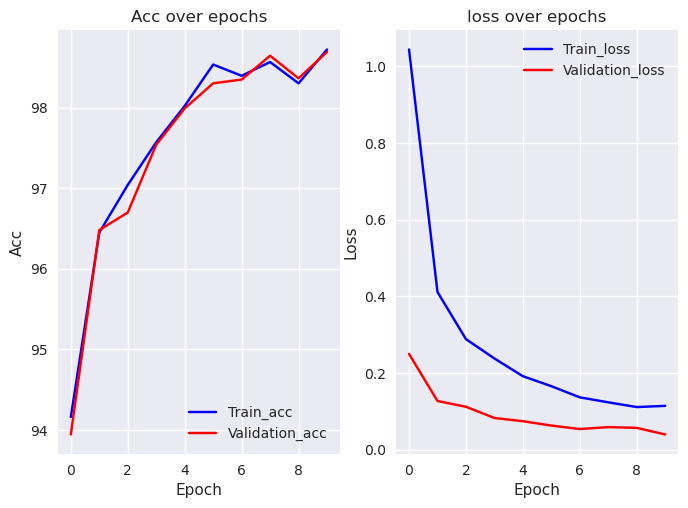

In [ ]:
model = OOD_Model(num_class=10, model_name="efficientnet_b0", pretrained=True) # vit_base_patch8_224 efficientnet_b0
model = model.to(device)

# Restore model if desired
if config['model_path'] != '':
    if os.path.isfile(config['model_path'] ):
        model.load_state_dict(torch.load(config['model_path']))

optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'])

loss_function = nn.CrossEntropyLoss()
model, optimizer, _ = training_loop(model, loss_function, optimizer, train_loader, val_loader, config["epochs"], device)